# When will the UK Population be Fully Vaccinated Against Covid-19?



In [1]:
from requests import get
from json import dumps

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc('figure', figsize=[12, 10])
plt.rc('font', size=fontsize)
plt.rc('axes', titlesize=fontsize)
plt.rc('axes', labelsize=fontsize)
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
figsize_21 = (width, 2*height)
%matplotlib inline

## Getting the data

In [2]:
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"
AREA_TYPE = "overview"

filters = [
    f"areaType={ AREA_TYPE }",
]
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}
api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))
}
response = get(ENDPOINT, params=api_params, timeout=10)

if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')


In [3]:
j = response.json()
print(j.keys())

dict_keys(['length', 'maxPageLimit', 'data', 'pagination'])


In [4]:
print(j["length"], j["maxPageLimit"])

86 2500


In [5]:
print(j["data"][0])

{'date': '2021-04-05', 'newFirst': 40744, 'cumFirst': 31622367, 'newSecond': 64590, 'cumSecond': 5496716}


In [6]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
df.index.name = ""
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
,,,,
2021-04-01,0.170818,31.318262,0.445416,4.958874
2021-04-02,0.107420,31.425682,0.246631,5.205505
2021-04-03,0.107886,31.533568,0.178913,5.384418
2021-04-04,0.048055,31.581623,0.047708,5.432126
2021-04-05,0.040744,31.622367,0.064590,5.496716


## Vaccines so far

In [7]:
# no. people getting vaccinations (in millions)
# https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf
priority_totals = {
    "Groups 1-4": 15,
    "Groups 1-9": 32,
    "All Adults": 53
}


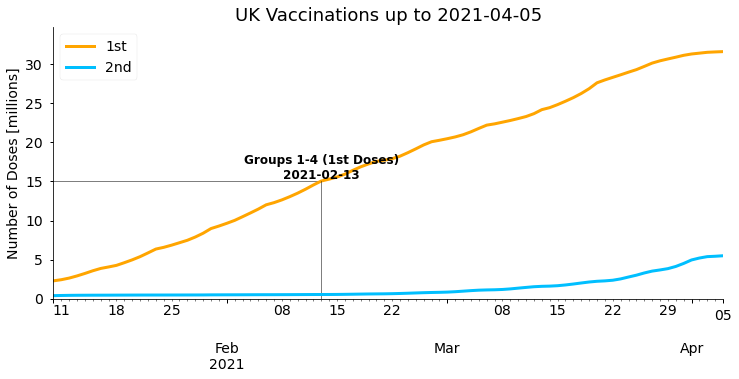

In [8]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    max_y = df["cumFirst"].max() * 1.1  # y-axis limit
    ax.set_ylim([0, max_y])
    text_offset = 1.02
    columns = ["cumFirst", "cumSecond"]
    labels = ["1st", "2nd"]
    colors = ["orange", "deepskyblue"]

    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab in zip(columns, colors, labels):
        # plot actual data with a solid line
        df[col][
            df[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=lab, linewidth=3)

        # plot forecast data with a dashed line
        if plot_forecast:
            df[col][
                df[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"{lab} (Forecast)")

        # label priority group completion dates
        max_col = df[col].max()
        for name, pop in priority_totals.items():
            if max_col >= (pop - 1e-7):  # vaccines completed for this group
                complete_date = df[df[col] >= (pop - 1e-7)].iloc[0].name

                ax.hlines(pop, 0, complete_date , color="k",linewidth=0.5)
                ax.axvline(complete_date, ymax=pop/max_y, color="k",linewidth=0.5)
                ax.text(
                    complete_date,
                    pop*text_offset,
                    f"{name} ({lab} Doses)\n{complete_date.date()}",
                    ha="center",
                    size=12,
                    fontweight="bold",
                )
            
    ax.legend()
    ax.set_ylabel("Number of Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_cumulative_doses(
    df, title=f"UK Vaccinations up to {df.index.date.max()}"
)

In [9]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]


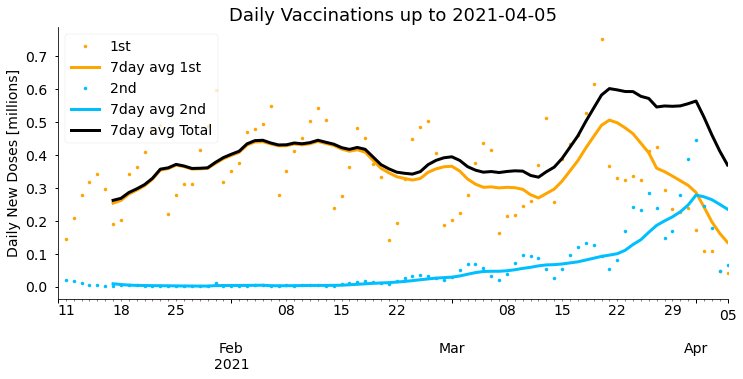

In [10]:
def plot_daily_doses(
    df, forecast_date=None, figsize=figsize, title=None
):
    """
    Plot daily first and second doses, the sum of 1st and 2nd doses,
    and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    columns = ["newFirst", "newSecond", "newTot"]
    labels = ["1st", "2nd", "Total"]
    colors = ["orange", "deepskyblue", "k"]
    show_daily = [True, True, False]

    n_avg = 7
    roll_avg = df.rolling(window=n_avg).mean()


    if forecast_date is None:
        forecast_date = df.index.max() + timedelta(days=1)
        plot_forecast = False
    else:
        plot_forecast = True
    
    for col, clr, lab, daily in zip(columns, colors, labels, show_daily):
        if daily:
            df[col].plot(color=clr, linestyle="None", marker=".", label=lab, ax=ax)

        # plot actual rolling average data with a solid line
        roll_avg[col][
            roll_avg[col].index <= forecast_date  # select rows of actual data 
        ].plot(color=clr, label=f"7day avg {lab}", linewidth=3)

        # plot forecast rolling average data with a dashed line
        if plot_forecast:
            roll_avg[col][
                roll_avg[col].index >= forecast_date  # select rows of forecasted data 
            ].plot(color=clr, linestyle="--", label=f"7day avg {lab} (Forecast)")
            
    ax.legend()
    ax.set_ylabel("Daily New Doses [millions]")
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_daily_doses(
    df, title=f"Daily Vaccinations up to {df.index.date.max()}"
)

Text(0, 0.5, 'Daily Doses (1st + 2nd) [millions]')

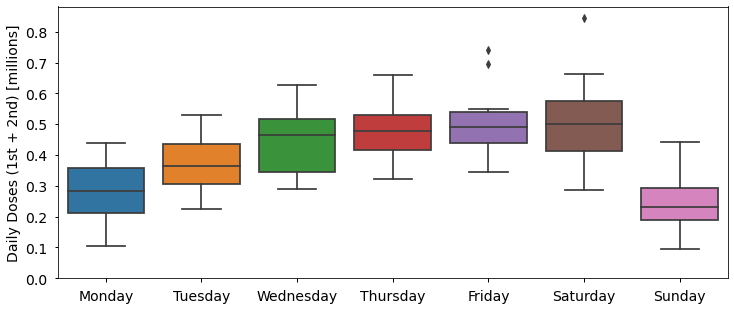

In [11]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday", y="newTot", data=df,
    order=[
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday",
        "Sunday"
    ]
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd) [millions]")

## When are 2nd doses being given?

days after 1st dose that 2nd dose given

3 to 12 weeks: https://www.gov.uk/government/publications/covid-19-vaccination-what-to-expect-after-vaccination/what-to-expect-after-your-covid-19-vaccination#what-to-do-next


In [12]:
for date_1st, row in df.iterrows():
    if row["cumFirst"] > df["cumSecond"].max():
        # reached the people who haven't been given the 2nd dose yet
        print(
            "1st doses from", (date_1st - timedelta(days=1)).date(),
            "were completed", delay, "days later, on", date_2nd.date()
        )
        break

    # find the earliest date where 2nd doses matched/exceded 1st
    # doses on this date
    date_2nd = df[df["cumSecond"] >= row["cumFirst"]].index.min()
    
    # calculate and save how many days it was until 2nd doses were given
    delay = (date_2nd - date_1st).days
    df.loc[date_1st, "delaySecond"] = delay
    

df["delaySecond"].describe()

1st doses from 2021-01-21 were completed 72 days later, on 2021-04-03


count    12.000000
mean     71.666667
std       0.651339
min      71.000000
25%      71.000000
50%      72.000000
75%      72.000000
max      73.000000
Name: delaySecond, dtype: float64

In [13]:
second_dose_days = df["delaySecond"].dropna()[-1]
print("We will assume second doses are given", second_dose_days, "days later.")

We will assume second doses are given 72.0 days later.


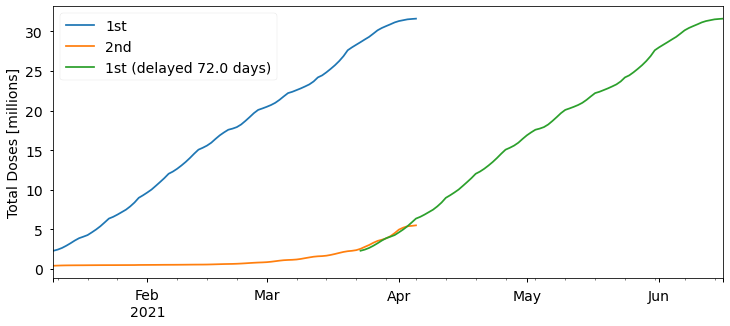

In [14]:
delayed_1st = df["cumFirst"].copy()
delayed_1st.index = delayed_1st.index + timedelta(days=second_dose_days)

plt.figure(figsize=figsize)
df["cumFirst"].plot(label="1st")
df["cumSecond"].plot(label="2nd")
delayed_1st.plot(label=f"1st (delayed {second_dose_days} days)")
plt.ylabel("Total Doses [millions]")
plt.legend()


## Forecasting Future Vaccinations

In [15]:
def lookback(df, date, days=7):
    return df.loc[date - timedelta(days=days), "newTot"]


def forecast_vaccines(
    df,
    second_dose_days,
    forecast_fn=lookback,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 11, 1)
):
    """
    Forecast vaccines assumming doses continue to be given at the
    same rate as the last week (or n_avg days) in the available data.

    df: DataFrame of actual vaccine data.
    second_dose_days: Days after 1st dose that 2nd dose is given.
    n_avg: Assume total doses today will be the same as total doses n_avg days ago.
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    # extend our time series index to the future
    first_data = df.index.min()
    last_data = df.index.max()
    df = df.append(pd.DataFrame(index=pd.date_range(last_data, end_date, closed="right")))
    df.sort_index(inplace=True)

    future_dates = pd.date_range(start=last_data + timedelta(days=1), end=end_date)
    for d in future_dates:
        if d - timedelta(days=second_dose_days) < first_data:
            # no 1st dose data second_dose_days ago, assume no 2nd doses required
            pending_2nd_doses = 0
        else:
            # no. second doses needed today is difference between total
            # 2nd doses so far and 1st doses second_dose_days ago (who
            # now require 2nd dose)
            dose2_req = df.loc[
                d - timedelta(days=second_dose_days), "cumFirst"
            ]
            dose2_sofar =  df.loc[
                d - timedelta(days=1), "cumSecond"
            ]
            pending_2nd_doses = max([0, dose2_req - dose2_sofar])

        # forecast to give same total doses today as n_avg days ago
        total_doses_today = forecast_fn(df, d)
        if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
            # but don't vaccinate more than the total population
            total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]
        df.loc[d, "newTot"] = total_doses_today

        # prioritise 2nd doses over 1st doses - give all 2nd doses required (or as
        # many as possible if the number required is more than the total doses available)
        dose2_today = min(pending_2nd_doses, total_doses_today)
        df.loc[d, "newSecond"] = dose2_today
        df.loc[d, "cumSecond"] = df.loc[d - timedelta(days=1), "cumSecond"] + df.loc[d, "newSecond"]

        # remaining vaccines given as new 1st doses
        dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
        dose1_today = min(total_doses_today - dose2_today, dose1_remaining)
        df.loc[d, "newFirst"] = dose1_today
        df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + df.loc[d, "newFirst"]

        df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]
        
    return df


df_forecast = forecast_vaccines(df, second_dose_days)

Text(0, 0.5, 'Total Doses [millions]')

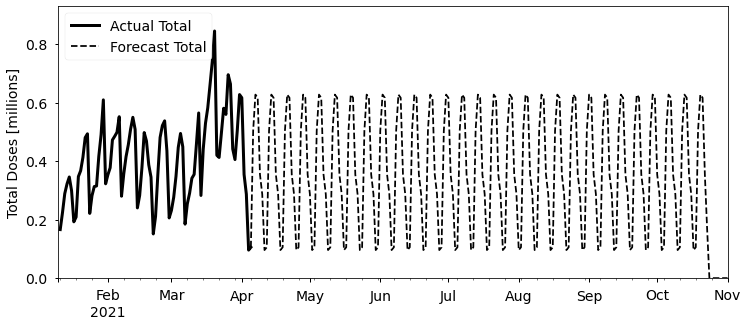

In [16]:
plt.figure(figsize=figsize)

total = df_forecast["newTot"]
last_data = df.index.max()
total[total.index <= last_data].plot(color="k", label="Actual Total", linewidth=3)
total[total.index >= last_data].plot(color="k", linestyle="--", label="Forecast Total")

plt.legend(loc="upper left")
plt.ylim([0, 1.1 * total.max()])
plt.ylabel("Total Doses [millions]")

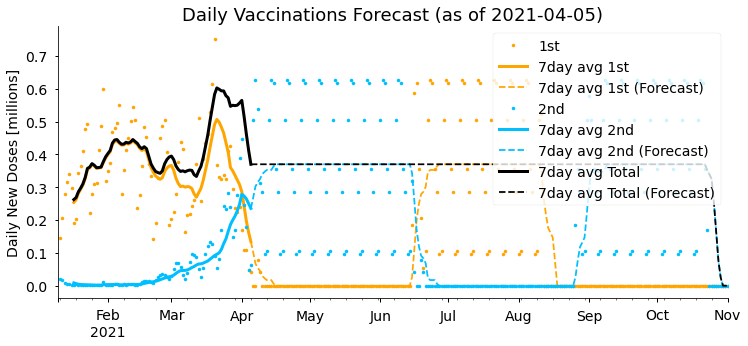

In [17]:
plot_daily_doses(
    df_forecast, forecast_date=last_data,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})"
)

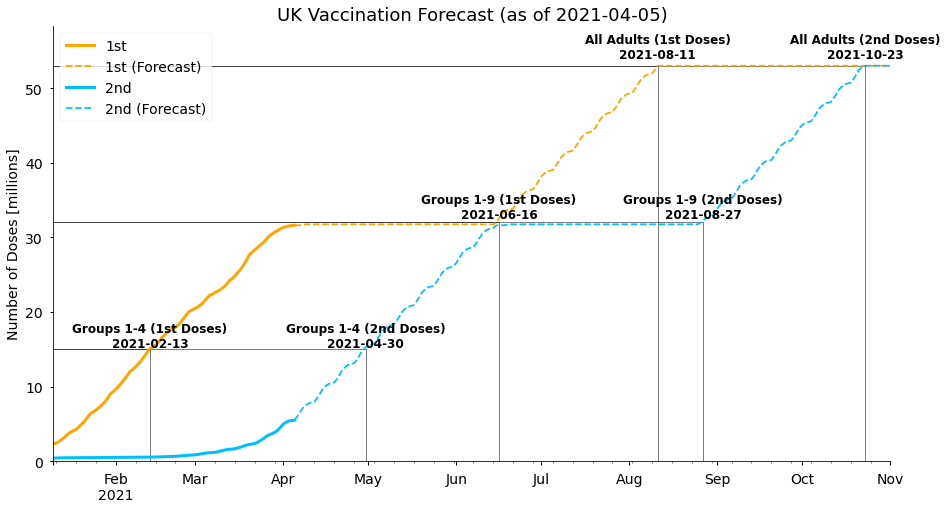

In [18]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})"
)

## Stability of Forecasts

In [19]:
def run_forecasts(
    df,
    run_start,
    second_dose_days,
    n_avg=7,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2022, 3, 1)
):
    """
    Calculate the completion date of the UK vaccination programme
    with different forecast start dates. A forecast is run as if
    it was every day starting from the date run_start, up to the
    date of the latest available data.
    """
    forecast_start_dates = pd.date_range(    
        start=run_start, end=df.index.max()
    )
    completion_dates = pd.Series(index=forecast_start_dates, dtype=float)
    for forecast_start in forecast_start_dates:
        df_forecast = forecast_vaccines(
            df[df.index <= forecast_start],
            second_dose_days,
            uk_pop=uk_pop, 
            end_date=end_date
        )
        if df_forecast["cumSecond"].max() >= (uk_pop - 1e-7):
            finish_date = df_forecast[df_forecast["cumSecond"] >= (uk_pop - 1e-7)].iloc[0].name
            completion_dates.loc[forecast_start] = finish_date
        else:
            print(forecast_start.date(), "forecast: Population not vaccinated by ", end_date.date(), "!!!")
            completion_dates.loc[forecast_start] = end_date
    
    return completion_dates

In [20]:
completion_dates = run_forecasts(df, datetime(2021, 2, 1), second_dose_days)

Text(0.5, 0, 'Forecast Date')

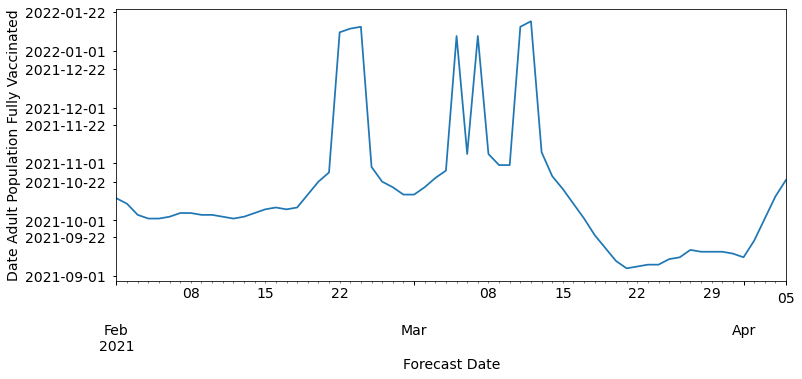

In [21]:
plt.figure(figsize=figsize)
completion_dates.plot()
plt.ylabel("Date Adult Population Fully Vaccinated")
plt.xlabel("Forecast Date")

Effect of Easter Bank Holiday

Stabilised mid-September?

There are several forecasts between late February and early March where the vaccine programme is not completed until January 2022, 2-3 months later than most forecasts at that time that have end dates in October. This looks a bit strange (why such big jumps?), but if we plot one of the forecasts with a late completion date we can see what's happening:

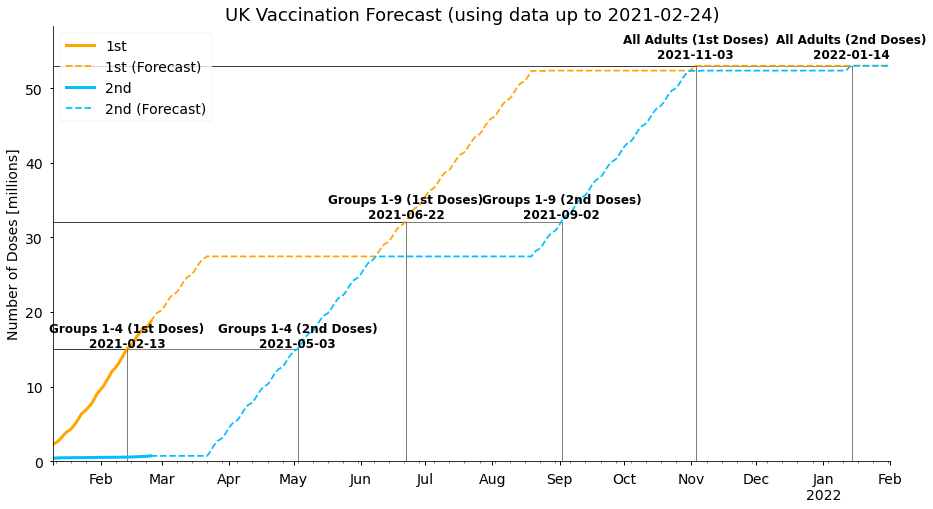

In [22]:
df_feb24 = forecast_vaccines(
    df[df.index <= datetime(2021, 2, 24)],
    second_dose_days,
    end_date=datetime(2022, 2, 1),
)
plot_cumulative_doses(
    df_feb24,
    forecast_date=datetime(2021, 2, 24),
    figsize=(15, 8), 
    title=f"UK Vaccination Forecast (using data up to {datetime(2021, 2, 24).date()})"
)

In the plot above, we see that in this forecast almost all adults are fully vaccinated by 20th August. However, before the remaining first doses can be given, a new batch of people requiring their second dose appear and must be given priority (without spare capacity for new first doses). 73 days later, on 1st November, the last few adults can start to be given their first dose. You'll notice that this 73 day delay in giving the last first doses is closely linked to the 72 day gap we assumed earlier between giving first doses and second doses. We can think of vaccines being given in alternating 72 day cycles of 1st doses and 2nd doses (at least in our simple forecast), and in the example above we have had to go through one additional cycle to complete the vaccination programme (compared to most forecasts which have completion datea in autumn 2021).

BUT
- assuming whole pop gets vaccinated etc.
- delay 2nd doses few days more in this case?

## Alternative Forecasts

In [23]:
weekly_avg = df["newTot"].resample("W").mean()

weekly_avg.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.279313
0.25    0.358341
0.50    0.391872
0.75    0.430859
0.90    0.526194
Name: newTot, dtype: float64

In [24]:
weekly_avg.describe()

count    13.000000
mean      0.385419
std       0.121095
min       0.105334
25%       0.358341
50%       0.391872
75%       0.430859
max       0.602266
Name: newTot, dtype: float64

In [25]:
def forecast_const(
    df,
    second_dose_days,
    daily_doses,
    uk_pop=priority_totals["All Adults"], 
    end_date=datetime(2021, 11, 1)
):
    """
    Forecast vaccines assumming daily_doses doses are given per day.

    df: DataFrame of actual vaccine data.
    first_data: Earliest date we have data for
    last_data: Latest date we have data for.
    second_dose_days: Days after 1st dose that 2nd dose is given.
    daily_doses: No. of doses to give per day
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    """
    def const_doses(df, date):
        return daily_doses
    
    df_forecast = forecast_vaccines(
        df,
        second_dose_days,
        forecast_fn=const_doses,
        uk_pop=uk_pop, 
        end_date=end_date,
    )

    return df_forecast


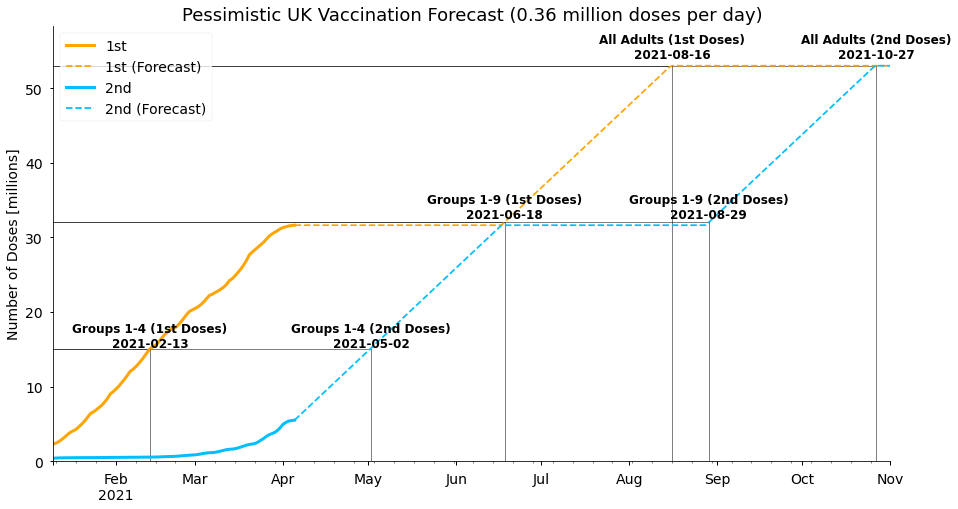

In [26]:
doses_per_day = weekly_avg.quantile(q=0.25)
df_q25 = forecast_const(
    df,
    second_dose_days,
    doses_per_day,
    uk_pop=priority_totals["All Adults"], 
)

plot_cumulative_doses(
    df_q25, forecast_date=last_data, figsize=(15, 8),
    title=f"Pessimistic UK Vaccination Forecast ({doses_per_day:.2f} million doses per day)"
)

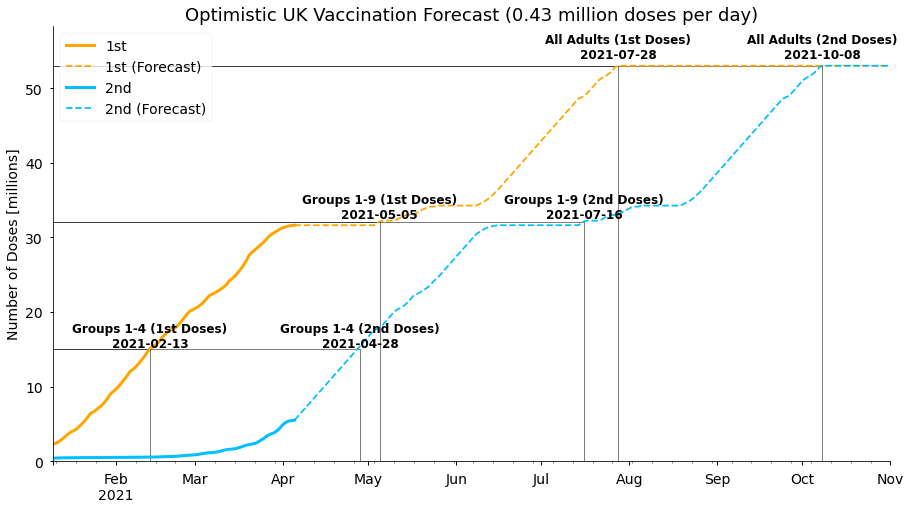

In [27]:
doses_per_day = weekly_avg.quantile(q=0.75)
df_q75 = forecast_const(
    df,
    second_dose_days,
    doses_per_day,
    uk_pop=priority_totals["All Adults"], 
)

plot_cumulative_doses(
    df_q75, forecast_date=last_data, figsize=(15, 8),
    title=f"Optimistic UK Vaccination Forecast ({doses_per_day:.2f} million doses per day)"
)

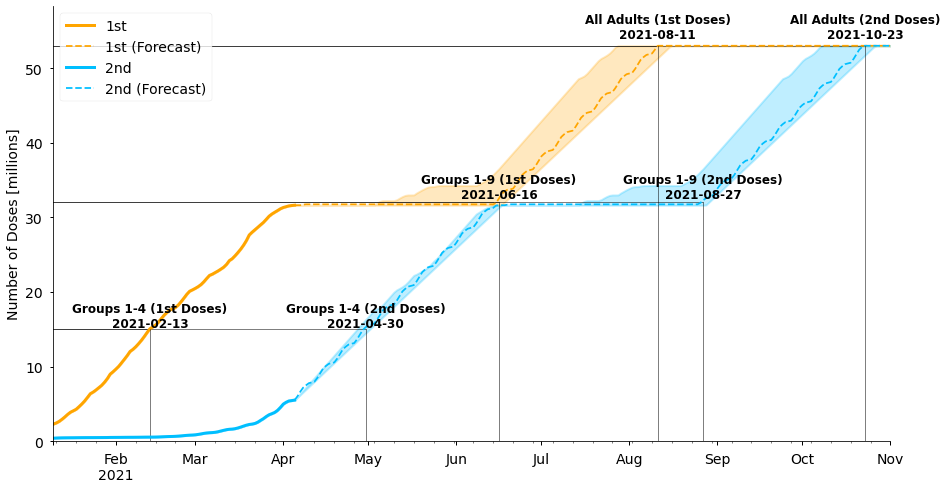

In [28]:
plot_cumulative_doses(
    df_forecast, forecast_date=last_data, figsize=(15, 8), 
)
plt.fill_between(
    df_q25.index, df_q25["cumFirst"],
    df_q75["cumFirst"], color='orange',
    alpha=0.25,
    linewidth=2
)
plt.fill_between(
    df_q25.index, 
    df_q25["cumSecond"],
    df_q75["cumSecond"],
    color='deepskyblue',
    alpha=0.25,
    linewidth=2
)


## Summary